In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
sys.path.append('../util')
sys.path.append('../explainers')

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch_geometric as pyg
import torch_geometric.transforms as T
from torch_geometric.datasets import ExplainerDataset, InfectionDataset
from torch_geometric.datasets.graph_generator import ERGraph
from torch_geometric.explain import Explainer
from torch_geometric.nn import GraphSAGE
from torch_geometric.utils import k_hop_subgraph

from layerwise_grad_explainer import LayerwiseGradExplainer
from gnnexplainer_layerwise import LayerwiseGNNExplainer
from utils import *

import matplotlib.pyplot as plt
torch.manual_seed(0)

In [5]:
device = torch.device('cuda:1')
directory = '/data/jesse/infection/'
dataset = torch.load(directory + 'infection_dataset.pt', map_location=device)
model = GraphSAGE(dataset.num_node_features,
                  hidden_channels=20, num_layers=4,
                  out_channels=6, aggr = 'sum').to(device)
state = torch.load(directory + 'model.pt', map_location=device)
model.load_state_dict(state)
data = dataset[-1]

In [6]:
_, _, mask = pyg.utils.remove_isolated_nodes(data.edge_index)
mask = mask.cpu()

In [7]:
full_preds = torch.load(directory + 'full_layerwise_preds.pt')[mask]

gi_expls = torch.load(directory + 'gi_preds.pt')[mask]
occ_expls = torch.load(directory + 'occ_preds.pt')[mask]
gnn_expls = torch.load(directory + 'gnnexplainer_preds.pt')[mask]
full_expls = torch.load(directory + 'full_layerwise_preds.pt')[mask,0,:]

l_grad_expls = torch.load(directory + 'grad_layerwise_preds.pt')[mask]
l_occ_expls = torch.load(directory + 'occ_layerwise_preds.pt')[mask]
l_gnn_expls = torch.load(directory + 'gnnexplainer_layerwise_preds.pt')[mask]
l_full_expls = torch.load(directory + 'full_layerwise_preds.pt')[mask]

rand_expls = torch.rand_like(full_expls)
l_rand_expls = torch.rand_like(l_full_expls)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

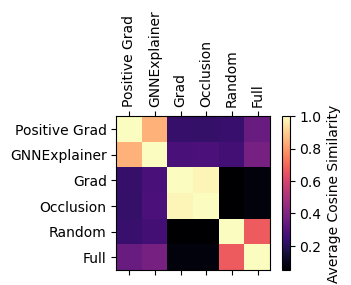

In [8]:
eps = 0.0
all_expls = torch.stack([gi_expls > eps, gnn_expls, gi_expls, occ_expls, rand_expls, full_expls])
all_mean_sims = torch.empty((6,6))
for i in range(6):
    for j in range(6):
        all_mean_sims[i,j] = F.cosine_similarity(all_expls[i], all_expls[j], 1).mean()
fig, ax = plt.subplots(figsize=(3,2))
im = ax.matshow(all_mean_sims, cmap='magma')
ax.set_xticks(ticks=range(0,6), labels = ['Positive Grad', 'GNNExplainer', 'Grad', 'Occlusion', 'Random', 'Full'], rotation=90)
ax.set_yticks(ticks=range(0,6), labels = ['Positive Grad', 'GNNExplainer', 'Grad', 'Occlusion', 'Random', 'Full'])
fig.colorbar(im, label = 'Average Cosine Similarity')
plt.savefig('../images/infection_matrix.svg')

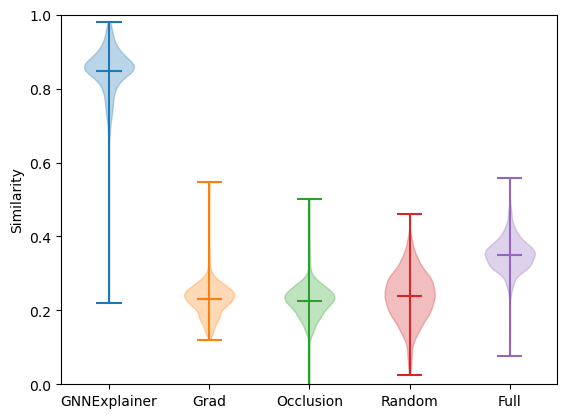

(tensor(0.8472), tensor(0.0672))

In [9]:
violins = plt.violinplot(
        [torch.nn.functional.cosine_similarity(gnn_expls, gi_expls > 0, 1),
         torch.nn.functional.cosine_similarity(gi_expls, gi_expls > 0, 1),
         torch.nn.functional.cosine_similarity(occ_expls, gi_expls > 0, 1),
         torch.nn.functional.cosine_similarity(rand_expls, gi_expls > 0, 1),
         torch.nn.functional.cosine_similarity(full_expls, gi_expls > 0, 1)],
        showmeans=True,
    )
for pc, color in zip(violins['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
violins['cbars'].set_colors(colors)
violins['cmins'].set_colors(colors)
violins['cmaxes'].set_colors(colors)
violins['cmeans'].set_colors(colors)
plt.xticks(ticks=range(1,6), labels = ['GNNExplainer', 'Grad', 'Occlusion', 'Random', 'Full'])
plt.ylabel('Similarity')
plt.ylim(0,1)
plt.show()

torch.nn.functional.cosine_similarity(gnn_expls, gi_expls > 0, 1).mean(), torch.nn.functional.cosine_similarity(gnn_expls, gi_expls > 0, 1).std()

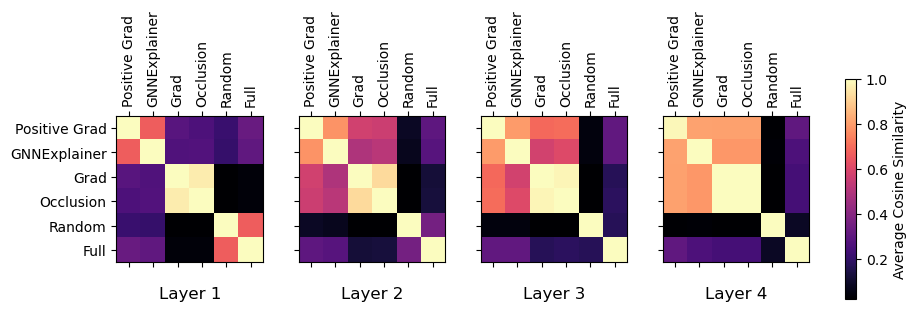

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(9,3), sharey = True, constrained_layout=True)
all_l_expls = torch.stack([l_grad_expls > eps, l_gnn_expls, l_grad_expls, l_occ_expls, l_rand_expls, full_preds])
for i in range(model.num_layers):
    ax = axes[i]
    all_mean_sims = torch.empty((6,6))
    for j in range(6):
        for k in range(6):
            all_mean_sims[j,k] = F.cosine_similarity(all_l_expls[j,:,i], all_l_expls[k,:,i], 1).mean()
    im = ax.matshow(all_mean_sims, cmap='magma')
    ax.set_xticks(ticks=range(0,6), labels = ['Positive Grad', 'GNNExplainer', 'Grad', 'Occlusion', 'Random', 'Full'], rotation=90)
    ax.set_yticks(ticks=range(0,6), labels = ['Positive Grad', 'GNNExplainer', 'Grad', 'Occlusion', 'Random', 'Full'])
    ax.set_title(f'Layer {i+1}', y = -.3)
fig.colorbar(im, ax=axes.ravel().tolist(), label = 'Average Cosine Similarity', shrink = 1.5)
plt.savefig('../images/infection__layerwise_matrix.svg')

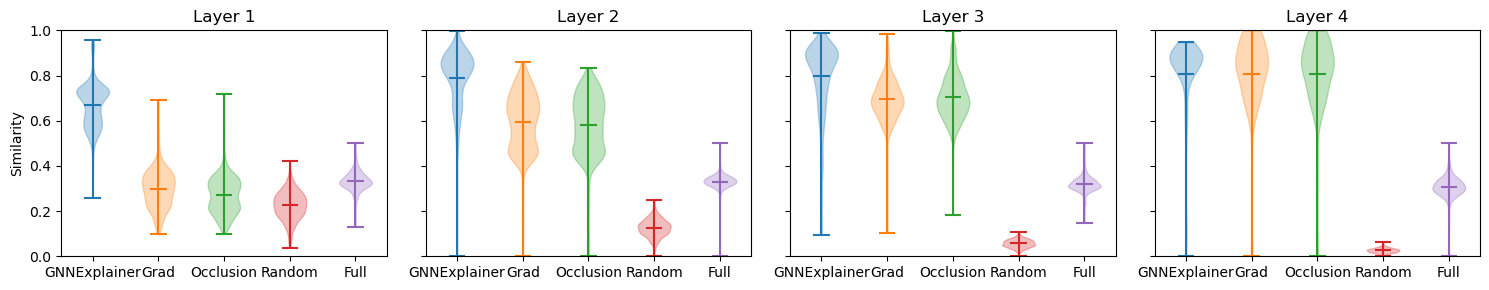

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(15,3), sharey = True)
for i in range(model.num_layers):
    violins = axes[i].violinplot(
            [torch.nn.functional.cosine_similarity(l_gnn_expls, l_grad_expls > 0, 2)[:,i],
            torch.nn.functional.cosine_similarity(l_grad_expls, l_grad_expls > 0, 2)[:,i],
            torch.nn.functional.cosine_similarity(l_occ_expls, l_grad_expls > 0, 2)[:,i],
            torch.nn.functional.cosine_similarity(l_rand_expls, l_grad_expls > 0, 2)[:,i],
            torch.nn.functional.cosine_similarity(l_full_expls, l_grad_expls > 0, 2)[:,i],
            ],
            showmeans=True,
        )
    for pc, color in zip(violins['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
    violins['cbars'].set_colors(colors)
    violins['cmins'].set_colors(colors)
    violins['cmaxes'].set_colors(colors)
    violins['cmeans'].set_colors(colors)
    axes[i].set_xticks(ticks=range(1,6), labels = ['GNNExplainer', 'Grad', 'Occlusion', 'Random', 'Full'])
    axes[i].set_title(f'Layer {i+1}')
axes[0].set_ylabel('Similarity')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

In [12]:
from torch_geometric.utils import get_embeddings
def _layer_grads(model, x, edge_index, index, target, layer):
    embeddings = get_embeddings(model, x, edge_index)
    num_layers = model.num_layers
    conv = model.convs[layer]
    if layer == 0:
        in_emb = x
    else:
        in_emb = model.act(embeddings[layer-1])
    in_emb = in_emb.detach().requires_grad_()
    def _apply_layer(in_emb):
        out = conv(in_emb, edge_index)[index]
        if layer + 1 < num_layers:
            out = model.act(out)
        elif layer + 1 == num_layers:
            out = out[target[index]]
        return out
    jacobian = torch.autograd.functional.jacobian(_apply_layer, in_emb)
    if jacobian.dim() != 3:
        jacobian = jacobian.unsqueeze(0)
    assert jacobian.dim() == 3
    return jacobian.detach()

In [13]:
data.to(device)

Explanation(x=[1000, 2], edge_index=[2, 4152], y=[1000], edge_mask=[4152])

In [14]:
from torch_geometric.utils import add_remaining_self_loops, k_hop_subgraph
def _best_paths(model, x, edge_index, index):
    device = x.device
    embeddings = get_embeddings(model, x, edge_index)
    for l in range(len(embeddings) - 1):
        embeddings[l] = model.act(embeddings[l])
    embeddings.reverse()
    embeddings.append(x)
    graph_layers = [k_hop_subgraph(index, l, edge_index) for l in range(model.num_layers+1)]
    scores = [{int(node) : -torch.inf for node in nodes} for nodes, _, _, _ in graph_layers]
    parents = [{int(node) : -1 for node in nodes} for nodes, _, _, _ in graph_layers]
    scores[0][index] = 0.

    cum_grads = [{int(node) : None for node in nodes} for nodes, _, _, _ in graph_layers]
    cum_grads[0][int(index)] = torch.tensor([[1.0]], device=device)

    edge_index = add_remaining_self_loops(edge_index)[0]
    for graph_layer, l_back in zip(graph_layers, range(model.num_layers)):
        nodes, _, _, _ = graph_layer
        for node in nodes:
            node = int(node)
            neighbors, _, _, _ = k_hop_subgraph(node, 1, edge_index)
            layer_grads = _layer_grads(model, data.x, data.edge_index, node, data.y, model.num_layers - l_back - 1)
            for neighbor in neighbors:
                neighbor = int(neighbor)
                new_cum_grad = cum_grads[l_back][node] @ layer_grads[:,neighbor,:]
                edge_score = new_cum_grad @ embeddings[l_back+1][neighbor]
                if edge_score > scores[l_back+1][neighbor]:
                    parents[l_back+1][neighbor] = node
                    scores[l_back+1][neighbor] = edge_score
                    cum_grads[l_back+1][neighbor] = new_cum_grad
    return scores, parents

In [15]:
from torch_geometric.utils import add_remaining_self_loops, k_hop_subgraph
def _amp_ave(model, x, edge_index, index):
    device = x.device
    embeddings = get_embeddings(model, x, edge_index)
    for l in range(len(embeddings) - 1):
        embeddings[l] = model.act(embeddings[l])
    embeddings.reverse()
    embeddings.append(x)
    graph_layers = [k_hop_subgraph(index, l, edge_index) for l in range(model.num_layers+1)]
    scores = [{int(node) : -torch.inf for node in nodes} for nodes, _, _, _ in graph_layers]
    parents = [{int(node) : -1 for node in nodes} for nodes, _, _, _ in graph_layers]
    scores[0][index] = 0.

    edge_index = add_remaining_self_loops(edge_index)[0]
    for graph_layer, l_back in zip(graph_layers, range(model.num_layers)):
        nodes, _, _, _ = graph_layer
        for node in nodes:
            node = int(node)
            neighbors, _, _, _ = k_hop_subgraph(node, 1, edge_index)
            layer_grads = _layer_grads(model, data.x, data.edge_index, node, data.y, model.num_layers - l_back - 1)
            for neighbor in neighbors:
                neighbor = int(neighbor)
                # AMP-ave averages over the LRP matrix columns
                edge_score = embeddings[l_back+1][neighbor] @ layer_grads[:,neighbor,:].mean(0)
                if edge_score + scores[l_back][node] > scores[l_back+1][neighbor]:
                    parents[l_back+1][neighbor] = node
                    scores[l_back+1][neighbor] = edge_score + scores[l_back][node]
    return scores, parents

In [16]:
from utils import walk_to_edge_set, edge_set_to_edge_mask

index = 50
neighbors, _, _, hard_edge_mask = k_hop_subgraph(index, data.y[index], data.edge_index)
# neighbors, _, _, hard_edge_mask = k_hop_subgraph(index, 4, data.edge_index)
hard_edge_mask = hard_edge_mask.cpu()
print(data.y[index], torch.bincount(data.y[neighbors])[0])
our_scores, our_parents = _best_paths(model, data.x, data.edge_index, index)
amp_scores, amp_parents = _amp_ave(model, data.x, data.edge_index, index)

our_path = [max(our_scores[-1], key=our_scores[-1].get)]
for i in range(1, 5):
    our_path.append(our_parents[-i][our_path[-1]])
our_mask = edge_set_to_edge_mask(walk_to_edge_set(our_path), data.edge_index)

amp_path = [max(amp_scores[-1], key=amp_scores[-1].get)]
for i in range(1, 5):
    amp_path.append(amp_parents[-i][amp_path[-1]])
amp_mask = edge_set_to_edge_mask(walk_to_edge_set(amp_path), data.edge_index)

print(our_path, amp_path)

tensor(3, device='cuda:1') tensor(1, device='cuda:1')
[960, 866, 340, 340, 50] [109, 9, 9, 340, 50]


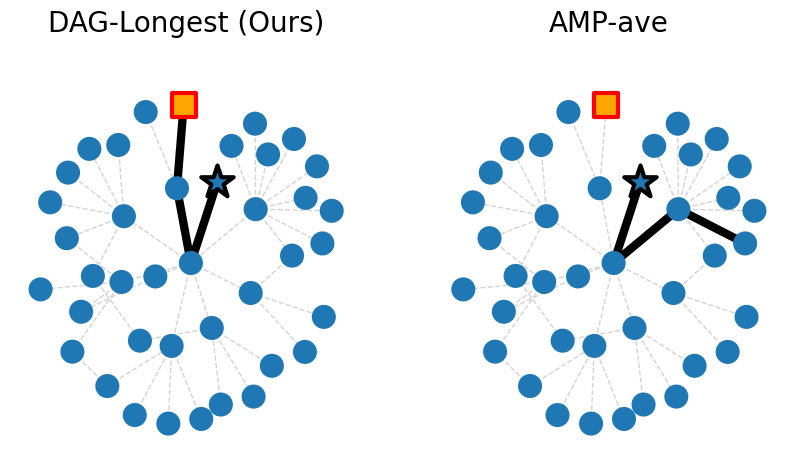

In [17]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import networkx as nx

edge_index = data.edge_index[:, hard_edge_mask].cpu()
edge_list = []
G = nx.DiGraph()
for j in range(edge_index.shape[1]):
    G.add_edge(int(edge_index[0,j]), int(edge_index[1,j]))
    edge_list.append((int(edge_index[0,j]), int(edge_index[1,j])))

our_mask_dict = {edge_list[j] : float(our_mask[hard_edge_mask][j])
                for j in range(G.number_of_edges())}

amp_mask_dict = {edge_list[j] : float(amp_mask[hard_edge_mask][j])
                for j in range(G.number_of_edges())}
for (u,v) in our_mask_dict:
    if (v,u) in our_mask_dict:
        our_mask_dict[(u,v)] = max(our_mask_dict[(u,v)],
                                   our_mask_dict[(v,u)])
for (u,v) in amp_mask_dict:
    if (v,u) in amp_mask_dict:
        amp_mask_dict[(u,v)] = max(amp_mask_dict[(u,v)],
                                   amp_mask_dict[(v,u)])

nx.set_edge_attributes(G, our_mask_dict, 'DAG-Longest')
nx.set_edge_attributes(G, amp_mask_dict, 'AMP-ave')

draw_graph = G.to_undirected()
for node in G:
    for ngbr in nx.neighbors(G, node):
        if node in nx.neighbors(G, ngbr):
            draw_graph.edges[node, ngbr]['DAG-Longest'] = (
                G.edges[node, ngbr]['DAG-Longest'] + G.edges[ngbr, node]['DAG-Longest']
            )
            draw_graph.edges[node, ngbr]['AMP-ave'] = (
                G.edges[node, ngbr]['AMP-ave'] + G.edges[ngbr, node]['AMP-ave']
            )
            
draw_nodes = neighbors.tolist()
draw_nodes.remove(int(index))
node_color = ["orange" if data.x[u][1] == 1. else '#1f78b4' for u in draw_nodes]
pos = nx.kamada_kawai_layout(G)
pos[index] = pos[index] + (0.1, 0.3)
fig, ax = plt.subplots(1, 2, figsize=(10,5))

node_outline = [3 if u == index else 0 for u in range(1,G.number_of_nodes())]

for i in range(2):
    nx.draw_networkx_edges(draw_graph, pos=pos, ax = ax[i],
                           edge_color = '#d3d3d3',
                          style = 'dashed')
    nx.draw_networkx_nodes(draw_graph, pos, ax=ax[i],
                       node_color = node_color,
                       linewidths = node_outline,
                       nodelist = draw_nodes)
    nx.draw_networkx_nodes(draw_graph, pos, ax=ax[i],
                           node_size=600,
                           node_shape = '*',
                           linewidths = 3,
                           edgecolors = 'black',
                       nodelist = [index])
    nx.draw_networkx_nodes(draw_graph, pos, ax=ax[i],
                           node_size=300,
                           node_color = 'orange',
                           node_shape = 's',
                           linewidths = 3,
                           edgecolors = 'red',
                       nodelist = [our_path[0]])
nx.draw_networkx_edges(draw_graph, pos=pos, ax = ax[0],
              width = [draw_graph[u][v]['DAG-Longest'] * 3 for u,v in draw_graph.edges])
nx.draw_networkx_edges(draw_graph, pos=pos, ax = ax[1],
              width = [draw_graph[u][v]['AMP-ave'] * 3 for u,v in draw_graph.edges])


ax[0].title.set_text('DAG-Longest (Ours)''\n')
ax[1].title.set_text('AMP-ave''\n')
for i in range(2):
    ax[i].title.set_size(20)
    ax[i].axis('off')
plt.savefig('../images/infection_paths.svg')

In [ ]:
import time
from statistics import mean, stdev
from tqdm.notebook import tqdm

our_correct = 0
amp_correct = 0
valid = 0

amp_times = []
our_times = []

pbar = tqdm(range(data.num_nodes))
for node in pbar:
    neighbors = pyg.utils.k_hop_subgraph(node, data.y[node], data.edge_index)[0]
    # Check that node is a valid explanation target with unique infection path
    if data.y[node] < 5 and torch.bincount(data.y[neighbors])[0] == 1:
        valid += 1
        our_start = time.time()
        our_scores, our_parents = _best_paths(model, data.x, data.edge_index, node)
        our_end = time.time()
        our_time = our_end - our_start
        our_times.append(our_time)

        amp_start = time.time()
        amp_scores, amp_parents = _amp_ave(model, data.x, data.edge_index, node)
        amp_end = time.time()
        amp_time = amp_end - amp_start
        amp_times.append(amp_time)

        our_path = [max(our_scores[-1], key=our_scores[-1].get)]
        amp_path = [max(amp_scores[-1], key=amp_scores[-1].get)]
        for i in range(1, 5):
            our_path.append(our_parents[-i][our_path[-1]])
            amp_path.append(amp_parents[-i][amp_path[-1]])
        our_path.reverse()
        amp_path.reverse()
        if data.y[our_path[-1]] == 0 and len(set(our_path)) == data.y[node] + 1:
            our_correct += 1
        # else:
        #     print(node, our_path, f'Ours Incorrect. Endpoint Classes: {int(data.y[node])}, {int(data.y[our_path[-1]])}')
        if data.y[amp_path[-1]] == 0 and len(set(amp_path)) == data.y[node] + 1:
            amp_correct += 1
        # else:
        #     print(node, amp_path, f'AMP-ave Incorrect. Endpoint Classes: {int(data.y[node])}, {int(data.y[amp_path[-1]])}')
        pbar.set_description(f'{valid} Valid Examples. Our Correct: {our_correct} ({our_time:.2f}s). AMP-ave Correct: {amp_correct} ({amp_time:.2f}s).')

In [41]:
print(f'Best Path (Ours) Accuracy: {100 * our_correct / valid:.2f}% Time: {mean(our_times):.2f} \u00B1 {stdev(our_times):.2f}s')
print(f'AMP-ave          Accuracy: {100 * amp_correct / valid:.2f}% Time: {mean(amp_times):.2f} \u00B1 {stdev(amp_times):.2f}s')

Best Path (Ours) Accuracy: 99.08% Time: 8.12 ± 5.48s
AMP-ave          Accuracy: 91.13% Time: 8.18 ± 5.52s
